# Objectives 

- Implement a machine-learning-based cyber-attack intrusion detection. 
- Visualize variables in network data and understand their correlation to cyber-attacks.
- Use Random Forest for classification and feature ranking.

In [576]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

The UNSW-NB15 dataset, created by the Cyber Range Lab at UNSW Canberra,Australia, is a comprehensive dataset for network intrusion detection.


- The dataset contains network packets captured in the Cyber Range Lab. It includes records of various types of cyber attacks, which are divided into training and testing sets.


- Training and Testing Sets: Partitioned into training set (175,341 records) and testing set (82,332 records) in the files UNSW_NB15_training-set.csv and UNSW_NB15_testing-set.csv, respectively.


- The dataset includes 43 variables related to monitoring the network, and 2 variables that define whether an attack occurs (label) and the types of attacks (attack_cat).


- Types of Attacks: The dataset contains nine types of attacks: Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode, and Worms.


**Source:**


- https://www.researchgate.net/publication/287330529_UNSW-NB15_a_comprehensive_data_set_for_network_intrusion_detection_systems_UNSW-NB15_network_data_set

In [577]:
# Load data
df_train = pd.read_csv('UNSW_NB15_training-set.csv')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv')

In [578]:
# display the first 5 rows of train data
df_train.head()

id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2                0   
1           0                 0           1           2                0   
2           0                 0           1           3                0   
3           0                 0           2           3                0   
4           0                 0           2           3                0   

   attack_cat  label  
0      Normal      0  
1      Normal      0  
2      Normal      0  
3      Normal      0  
4      Normal      0  

[5 rows x 45 columns]

In [579]:
# print the size of the train data
print(f'size of train data is {df_train.shape} ')

size of train data is (82332, 45) 


In [580]:
# display the first 5 rows of test data
df_test.head()

id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0           1           1                0      Normal   
1                 0           1           6                0      Normal   
2                 0           2           6                0      Normal   
3                 0           2           1                0      Normal   
4                 0           2          39                0      Normal   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 45 columns]

In [581]:
# print the size of the train data
print(f'size of test data is {df_test.shape} ')

size of test data is (175341, 45) 


In [582]:
# Displaying network variable descriptions 

def create_styled_table(data, caption):
    df = pd.DataFrame(data)
    styled_table = df.style.set_table_styles(
        [{'selector': 'table', 'props': [('border-collapse', 'collapse')]},
         {'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '8px')]}]
    ).set_caption(caption)
    return styled_table

# Data for Table 1. Flow Features
data_table_1 = {
    "#": [1, 2, 3, 4, 5],
    "Name": ["srcip", "sport", "dstip", "dsport", "proto"],
    "T.": ["N", "I", "N", "I", "N"],
    "Description": [
        "Source IP address",
        "Source port number",
        "Destination IP address",
        "Destination port number",
        "Transaction protocol"
    ]
}

# Data for Table 2. Basic Features
data_table_2 = {
    "#": list(range(6, 19)),
    "Name": ["state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "sload", "dload", "spkts", "dpkts"],
    "T": ["N", "F", "I", "I", "I", "I", "I", "I", "N", "F", "F", "I", "I"],
    "Description": [
        "The state and its dependent protocol, e.g. ACC, CLO, else (-)",
        "Record total duration",
        "Source to destination bytes",
        "Destination to source bytes",
        "Source to destination time to live",
        "Destination to source time to live",
        "Source packets retransmitted or dropped",
        "Destination packets retransmitted or dropped",
        "http, ftp, ssh, dns ...else (-)",
        "Source bits per second",
        "Destination bits per second",
        "Source to destination packet count",
        "Destination to source packet count"
    ]
}

# Data for Table 3. Content Features
data_table_3 = {
    "#": list(range(19, 27)),
    "Name": ["swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len"],
    "T": ["I", "I", "I", "I", "I", "I", "I", "I"],
    "Description": [
        "Source TCP window advertisement",
        "Destination TCP window advertisement",
        "Source TCP sequence number",
        "Destination TCP sequence number",
        "Mean of the flow packet size transmitted by the src",
        "Mean of the flow packet size transmitted by the dst",
        "the depth into the connection of http request/response transaction",
        "The content size of the data transferred from the server’s http service"
    ]
}

# Data for Table 4. Time Features
data_table_4 = {
    "#": list(range(27, 36)),
    "Name": ["sjit", "djit", "stime", "ltime", "sintpkt", "dintpkt", "tcprtt", "synack", "ackdat"],
    "T": ["F", "F", "T", "T", "F", "F", "F", "F", "F"],
    "Description": [
        "Source jitter (mSec)",
        "Destination jitter (mSec)",
        "record start time",
        "record last time",
        "Source inter-packet arrival time (mSec)",
        "Destination inter-packet arrival time (mSec)",
        "The sum of 'synack' and 'ackdat' of the TCP.",
        "The time between the SYN and the SYN_ACK packets of the TCP.",
        "The time between the SYN_ACK and the ACK packets of the TCP."
    ]
}

# Data for Table 5. Additional Generated Features
data_table_5 = {
    "#": list(range(36, 48)),
    "Name": [
        "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd",
        "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm"
    ],
    "T": ["B", "I", "I", "B", "I", "I", "I", "I", "I", "I", "I", "I"],
    "Description": [
        "If source (1) equals to destination (3) IP addresses and port numbers (2)(4) are equal, this variable takes value 1 else 0",
        "No. for each state (6) according to specific range of values for source/destination time to live (10)(11).",
        "No. of flows that has methods such as Get and Post in http service.",
        "If the ftp session is accessed by user and password then 1 else 0.",
        "No of flows that has a command in ftp session.",
        "No. of connections that contain the same service (14) and source address (1) in 100 connections according to the last time (26).",
        "No. of connections that contain the same service (14) and destination address (3) in 100 connections according to the last time (26).",
        "No. of connections of the same destination address (3) in 100 connections according to the last time (26).",
        "No. of connections of the same source address (1) in 100 connections according to the last time (26).",
        "No. of connections of the same source address (1) and the destination port (4) in 100 connections according to the last time (26).",
        "No. of connections of the same destination address (3) and the source port (2) in 100 connections according to the last time (26).",
        "No. of connections of the same source (1) and the destination (3) address in 100 connections according to the last time (26)."
    ]
}

# Generate and display the tables
styled_table_1 = create_styled_table(data_table_1, 'Table 1. Flow Features')
styled_table_2 = create_styled_table(data_table_2, 'Table 2. Basic Features')
styled_table_3 = create_styled_table(data_table_3, 'Table 3. Content Features')
styled_table_4 = create_styled_table(data_table_4, 'Table 4. Time Features')
styled_table_5 = create_styled_table(data_table_5, 'Table 5. Additional Generated Features')


In [583]:
styled_table_1

In [584]:
styled_table_2

In [585]:
styled_table_3

In [586]:
styled_table_4

In [587]:
styled_table_5

# Exploratory Data Analysis


In [588]:
# Joining the two dataframes along the rows (Vertical concatenation)
df = pd.concat ( [df_train,df_test], axis = 0 ,join ='outer').drop(['id'], axis=1).reset_index(drop=True)
# print the new dataframe shape
print(df.shape)

(257673, 44)


In [589]:
# Dispaly the first five rows of the new dataframe
df.head()

dur proto service state  spkts  dpkts  sbytes  dbytes         rate  \
0  0.000011   udp       -   INT      2      0     496       0   90909.0902   
1  0.000008   udp       -   INT      2      0    1762       0  125000.0003   
2  0.000005   udp       -   INT      2      0    1068       0  200000.0051   
3  0.000006   udp       -   INT      2      0     900       0  166666.6608   
4  0.000010   udp       -   INT      2      0    2126       0  100000.0025   

   sttl  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0   254  ...                 1               2             0           0   
1   254  ...                 1               2             0           0   
2   254  ...                 1               3             0           0   
3   254  ...                 1               3             0           0   
4   254  ...                 1               3             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0           1           2                0      Normal   
1                 0           1           2                0      Normal   
2                 0           1           3                0      Normal   
3                 0           2           3                0      Normal   
4                 0           2           3                0      Normal   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 44 columns]

In [590]:
# dataframe info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  di

In [591]:
# Checking missing data
df.isnull().any().any()

False

In [592]:
# printing the type of attacks
print( f'Attack types are: {df["attack_cat"].unique()}')

Attack types are: ['Normal' 'Reconnaissance' 'Backdoor' 'DoS' 'Exploits' 'Analysis'
 'Fuzzers' 'Worms' 'Shellcode' 'Generic']




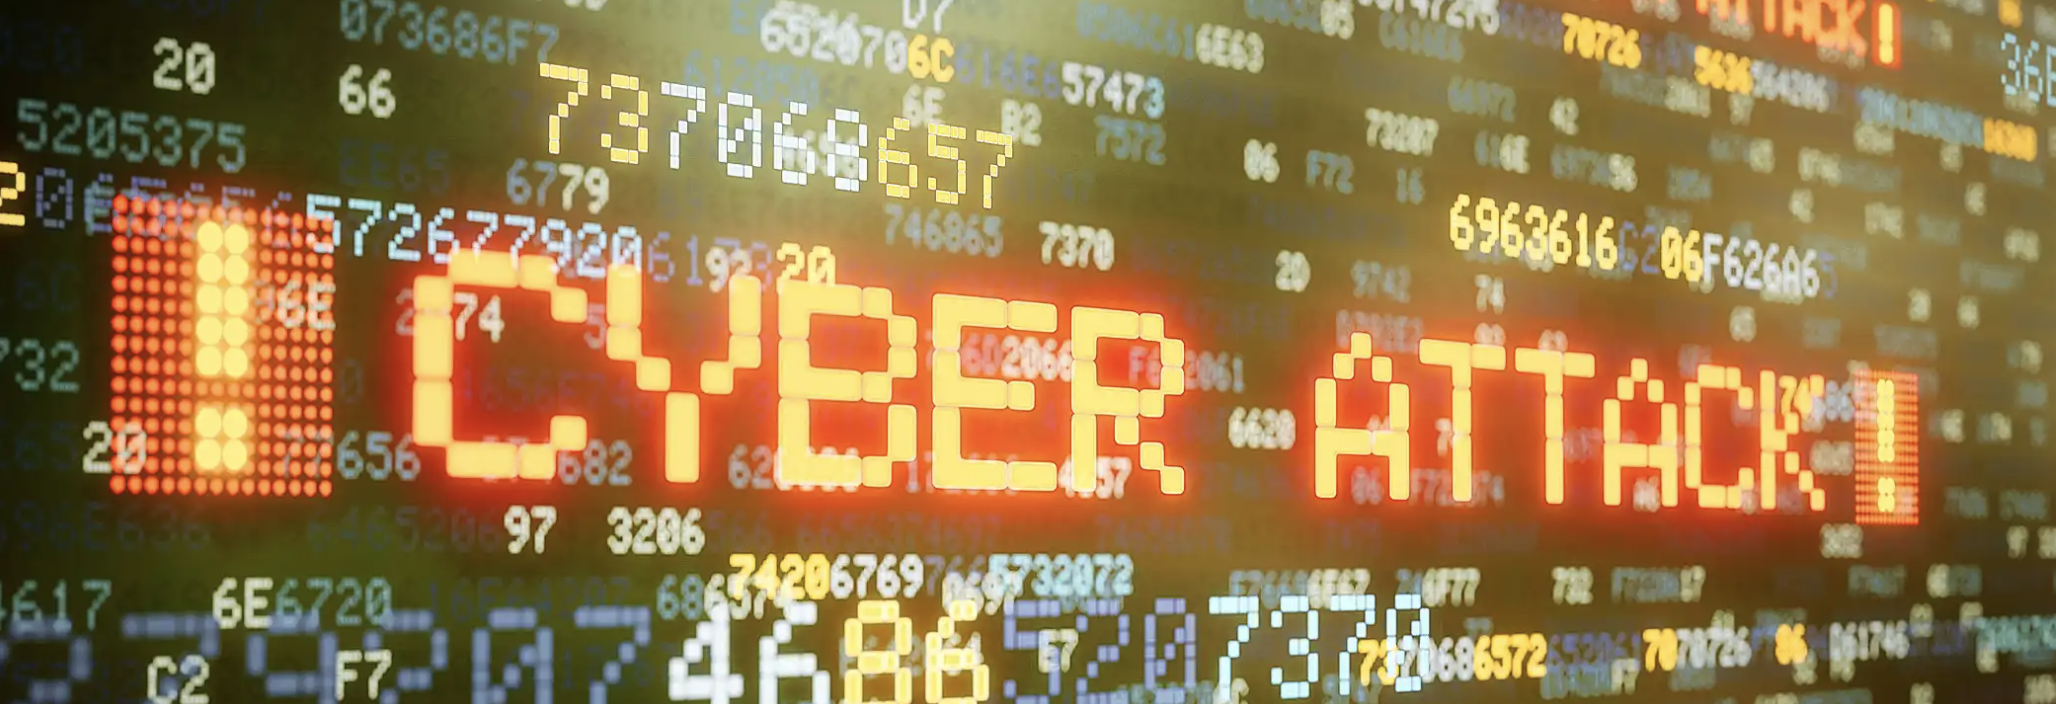

Note: 
Types of attacks are described as follows :


1. **Fuzzers**: An attack where the hacker sends random data to find security loopholes in the operating system, program, or network, potentially causing crashes or suspensions.

2. **Analysis**: An intrusion type that gains unauthorized access to web applications through port scanning, malicious scripting, and spamming.

3. **Backdoor**: A technique where an intruder bypasses normal authentication to gain unauthorized remote access to a system.

4. **DoS (Denial of Service)**: An attack where the hacker disrupts computing resources, making them unavailable to authorized users.

5. **Exploit**: Attacks that use software vulnerabilities, errors, or glitches in operating systems or applications.

6. **Generic**: Attacks targeting cryptographic systems to break the security key.

7. **Reconnaissance**: Attacks that begin with network scanning from an infected endpoint to locate targets. Includes active, random IP, and stealth scanning.

8. **Shellcode**: A malicious software attack where a small piece of code is executed to control a compromised machine.

9. **Worm**: Malicious software that replicates itself and spreads to other computers via the network, exploiting security failures on the target computers.

Source : https://prcrepository.org/xmlui/bitstream/handle/20.500.12475/1059/Articulo%20Final_%20Luis%20O.%20Sanchez.pdf?sequence=1&isAllowed=y

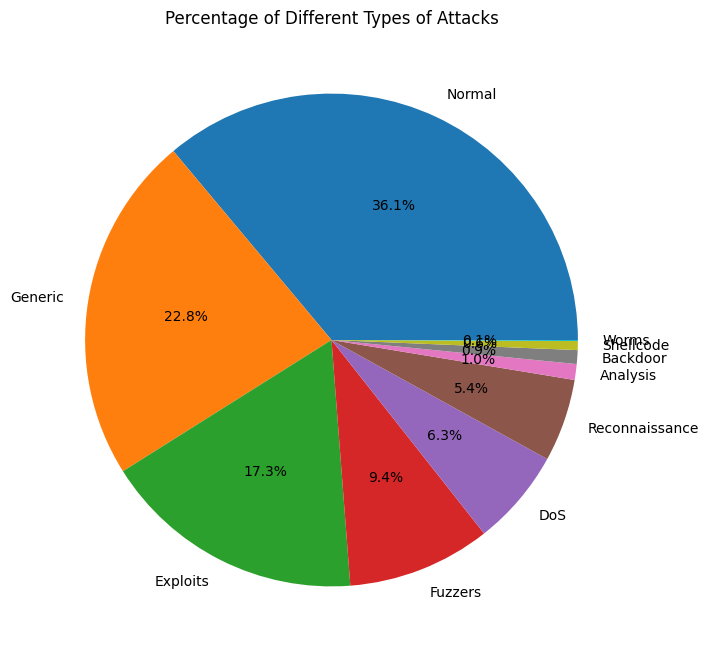

In [593]:
# Pie chart for different types of attacks

attack_counts = df['attack_cat'].value_counts()
attack_labels = attack_counts.index
attack_sizes = attack_counts.values

plt.figure(figsize=(8,8))
plt.pie( attack_sizes, labels = attack_labels, autopct = '%1.1f%%')
plt.title('Percentage of Different Types of Attacks')
plt.show()




**Note:** 

We have 4 categorical columns: 
- proto
- state
- service
- attack_cat

In [594]:
# printing the types of protocols
df['proto'].unique()

array(['udp', 'arp', 'tcp', 'igmp', 'ospf', 'sctp', 'gre', 'ggp', 'ip',
       'ipnip', 'st2', 'argus', 'chaos', 'egp', 'emcon', 'nvp', 'pup',
       'xnet', 'mux', 'dcn', 'hmp', 'prm', 'trunk-1', 'trunk-2',
       'xns-idp', 'leaf-1', 'leaf-2', 'irtp', 'rdp', 'netblt', 'mfe-nsp',
       'merit-inp', '3pc', 'idpr', 'ddp', 'idpr-cmtp', 'tp++', 'ipv6',
       'sdrp', 'ipv6-frag', 'ipv6-route', 'idrp', 'mhrp', 'i-nlsp', 'rvd',
       'mobile', 'narp', 'skip', 'tlsp', 'ipv6-no', 'any', 'ipv6-opts',
       'cftp', 'sat-expak', 'ippc', 'kryptolan', 'sat-mon', 'cpnx', 'wsn',
       'pvp', 'br-sat-mon', 'sun-nd', 'wb-mon', 'vmtp', 'ttp', 'vines',
       'nsfnet-igp', 'dgp', 'eigrp', 'tcf', 'sprite-rpc', 'larp', 'mtp',
       'ax.25', 'ipip', 'aes-sp3-d', 'micp', 'encap', 'pri-enc', 'gmtp',
       'ifmp', 'pnni', 'qnx', 'scps', 'cbt', 'bbn-rcc', 'igp', 'bna',
       'swipe', 'visa', 'ipcv', 'cphb', 'iso-tp4', 'wb-expak', 'sep',
       'secure-vmtp', 'xtp', 'il', 'rsvp', 'unas', 'fc', 'iso-ip',


In [595]:
# Printing the types of services
print(df['service'].unique())

['-' 'http' 'ftp' 'ftp-data' 'smtp' 'pop3' 'dns' 'snmp' 'ssl' 'dhcp' 'irc'
 'radius' 'ssh']


In [596]:
# Printing the types of states
print(df['state'].unique())

['INT' 'FIN' 'REQ' 'ACC' 'CON' 'RST' 'CLO' 'ECO' 'PAR' 'URN' 'no']


In [597]:
# let's encode all categorical columns using pandas method ( also possible with label encoder of sklearn)

#for col in ['proto','state','service','attack_cat']:
for col in df.select_dtypes(include=['object']).columns:    
    df[col] = df[col].astype('category').cat.codes

# show the first 5 rows of the df 
df.head()

dur  proto  service  state  spkts  dpkts  sbytes  dbytes         rate  \
0  0.000011    119        0      5      2      0     496       0   90909.0902   
1  0.000008    119        0      5      2      0    1762       0  125000.0003   
2  0.000005    119        0      5      2      0    1068       0  200000.0051   
3  0.000006    119        0      5      2      0     900       0  166666.6608   
4  0.000010    119        0      5      2      0    2126       0  100000.0025   

   sttl  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0   254  ...                 1               2             0           0   
1   254  ...                 1               2             0           0   
2   254  ...                 1               3             0           0   
3   254  ...                 1               3             0           0   
4   254  ...                 1               3             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0           1           2                0           6   
1                 0           1           2                0           6   
2                 0           1           3                0           6   
3                 0           2           3                0           6   
4                 0           2           3                0           6   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 44 columns]

# Data Correlation Analysis

- I will use a heatmap to conduct a correlation analysis to visualize and understand the correlation between network variables and their associations with cyber attacks.


- Additionally, I will determine which variables are more associated with each type of cyber attack.

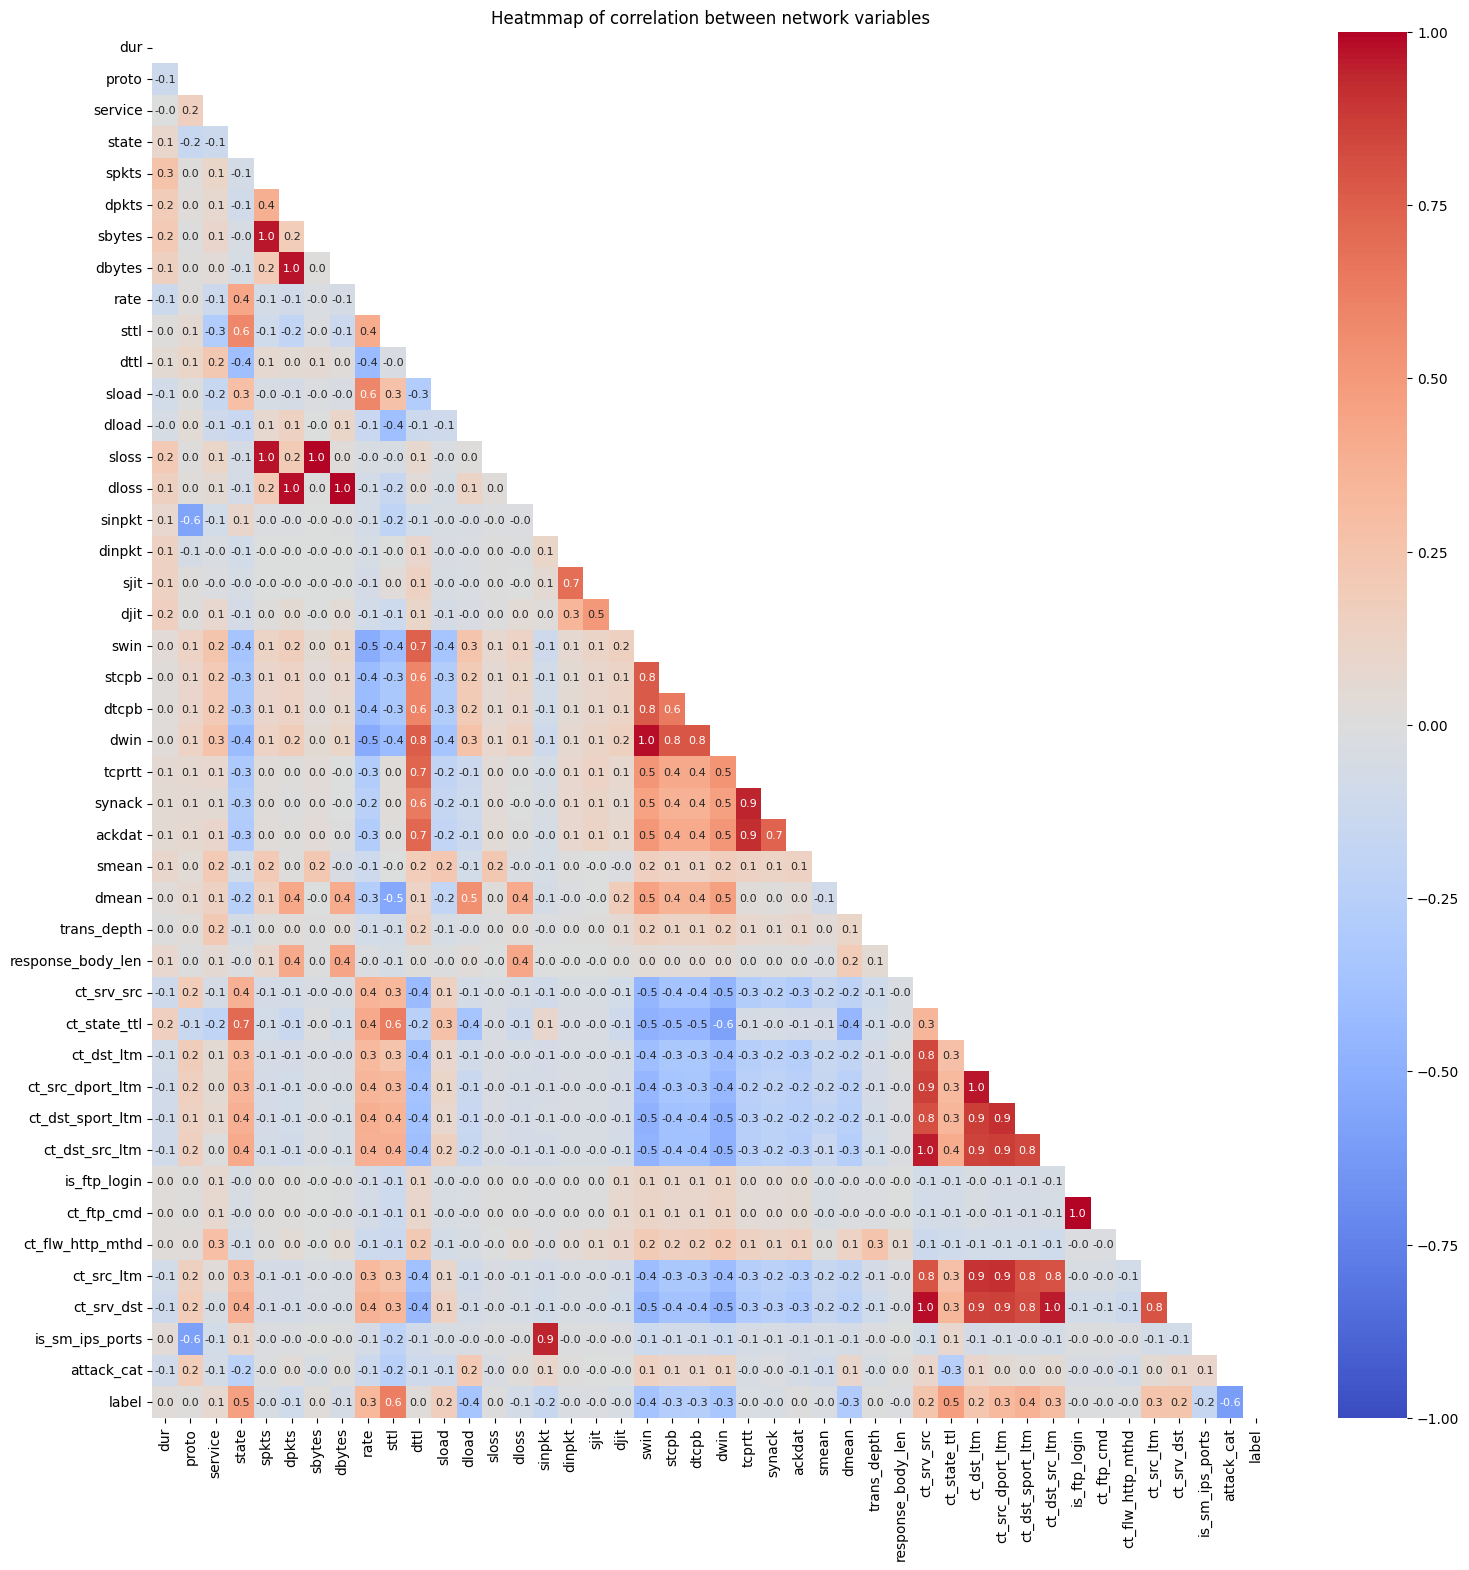

In [598]:
# Compute correlation matrix
corr = df.corr()

# Set up the  matplotlib figure
plt.figure(figsize=(18,18))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heaptmap
sns.heatmap(corr, mask = mask, annot= True,cmap='coolwarm',  vmin=-1, vmax=1,  fmt='.1f', annot_kws={"size": 8} )
plt.title('Heatmmap of correlation between network variables')
plt.show()



**Note:**

For a correlation heatmap, the vmin and vmax parameters should typically be set between -1 and 1. These values represent the minimum and maximum possible correlation values, respectively, where:

- -1 indicates a perfect negative correlation.
- 0 indicates no correlation.
- 1 indicates a perfect positive correlation.


**Variables Positively Correlated with Cyber Attack:**

1. `sttl (Source to destination time to live) - Positive correlation (0.62):`
   - Explanation: A high correlation between sttl and cyber attacks indicates that attackers often manipulate the TTL values to evade detection and prolong the packet's journey in the network. This can `be used to confuse tracking systems or to keep the connection alive longer.

2. `state - Positive correlation (0.46):`
   - Explanation: The state variable captures the state of a network connection. High correlation with attacks suggests that certain connection states (e.g., SYN, SYN-ACK) are more frequent during attack scenarios, such as during SYN flood attacks or other TCP-based attacks aiming to exhaust server resources.

3. `rate - Positive correlation (0.34):`
   -Explanation: This refers to the rate of packet transmission. During an attack, the transmission rate can significantly increase as attackers flood the network with packets to overwhelm the target system, leading to denial-of-service conditions.

4. `ct_state_ttl - Positive correlation (0.5):`
   - Explanation: This variable measures the number of connections with similar state and TTL values. A high correlation with attacks suggests that repeated patterns in connection states and TTL values are characteristic of automated attack tools, which generate similar packets rapidly.

5. `ct_dst_sport_ltm - Positive correlation (0.4):`
   - Explanation: This variable counts the number of connections to the same destination port over time. High correlation indicates that specific ports are targeted frequently, which is a common behavior in port scanning and other reconnaissance activities preceding an attack.




**Variables Negatively Correlated with Cyber Attack:**

1. `swin (Source TCP window advertisement) - Negative correlation (-0.4):`
   - **Explanation**: A negative correlation with cyber attacks suggests that normal traffic often has larger TCP window sizes compared to attack traffic. During attacks, especially DDoS or flood attacks, attackers might not fully utilize the window size to maximize the rate of packet transmission, thereby maintaining smaller window sizes to reduce latency and increase the attack's impact.

2. `dload (Destination bits per second) - Negative correlation (-0.4):`
   - Explanation: A negative correlation with cyber attacks implies that during an attack, the legitimate load on the destination server decreases. This can occur because attack traffic overwhelms the server, preventing it from serving legitimate traffic effectively. Consequently, the overall data throughput to legitimate users decreases, reflecting a lower dload value during attack scenarios.

In summary, the negative correlations of these variables with cyber attacks highlight that certain characteristics of normal traffic—such as larger TCP window sizes and higher legitimate data throughput—are diminished during attack conditions. Monitoring these variables can aid in distinguishing between normal and attack traffic, enhancing the detection and mitigation of cyber threats.

**Strong Correlations Among Variables:**

*TCP connection variables*

- tcprtt and ackdat: High positive correlation (0.9)
- tcprtt and synack: High positive correlation (0.9)
- ackdat and synack: High positive correlation (0.7)




*Other*

- sbytes and spkts: High positive correlation (0.96)
- dpkts and dbytes: High positive correlation (0.97)
- sloss and sbytes: High positive correlation (0.99)
- dloss and dpkts: High positive correlation (0.98)



*Comment:* 


Certain features are highly correlated, such as tcprtt with ackdat and synack, because they measure different aspects of the same TCP connection setup process. 
- tcprtt : is the round-trip time for the TCP connection to be establish
- ackdat : measures the time between the SYN_ACK and ACK packets.
- synack:  measures the time between the SYN and SYN_ACK packets.

These variables are all related to establishing a TCP connection, which explains their high correlation.





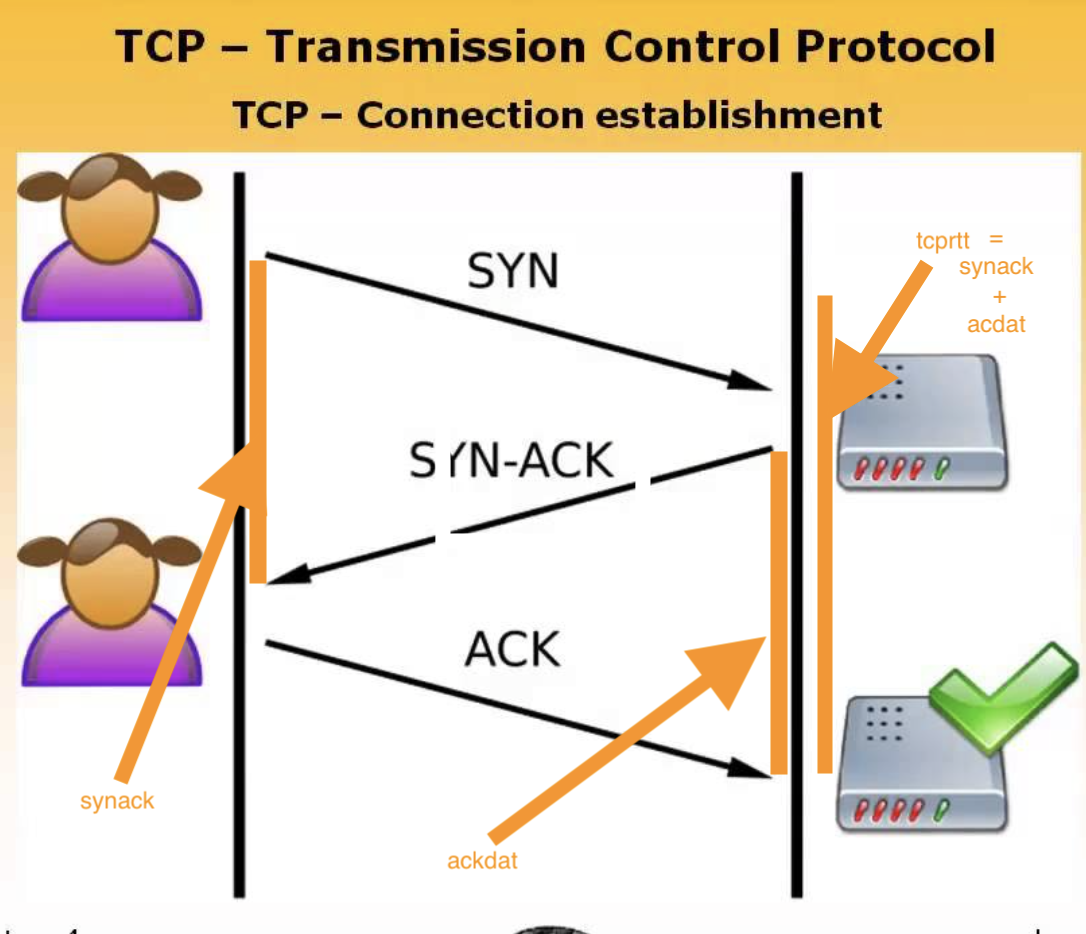


# Data  Seperation and Split 

In [599]:
# let's encode all categorical columns using pandas method 


# Encode categorical columns in df_train
df_train = df_train.apply(lambda col: col.astype('category').cat.codes if col.dtype == 'object' else col)

# Encode categorical columns in df_test
df_test = df_test.apply(lambda col: col.astype('category').cat.codes if col.dtype == 'object' else col)


In [600]:
# split the data into train and test set
X_train = df_train.iloc[: , :-1]
X_test = df_test.iloc[: , :-1]
y_train = df_train['label']
y_test = df_test['label']
# print shapes of train and test data
print ( f' X_train shape {X_train.shape}')
print ( f' X_test shape {X_test.shape}')
print ( f' y_train shape {y_train.shape}')
print ( f' y_test shape {y_test.shape}')

 X_train shape (82332, 44)
 X_test shape (175341, 44)
 y_train shape (82332,)
 y_test shape (175341,)


In [601]:
# checking if training data is imbalanced 
y_train.value_counts()

label
1    45332
0    37000
Name: count, dtype: int64

# Classification Model : Random Forest 

In [602]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score , confusion_matrix


# Train the model 
model = RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [603]:
# Make predictions:
y_pred = model.predict(X_test)

In [604]:
# compute accuracy score 
accuracy = accuracy_score(y_test, y_pred) 
recall = recall_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred) 
print( f'Accuracy score using Random Forest for cyberattack detection is : {accuracy}')
print( f'Recall score using Random Forest for cyberattack detection is : {recall}')
print( f'Precision score using Random Forest for cyberattack detection is : {precision}')

Accuracy score using Random Forest for cyberattack detection is : 0.9523956176821166
Recall score using Random Forest for cyberattack detection is : 0.9300743248338794
Precision score using Random Forest for cyberattack detection is : 0.9999819816573272



### Interpretation:

- `Accuracy: 95.24%`
  - This indicates that 95.24% of the predictions made by the model are correct.

- `Recall: 93.07%`
  - This indicates that the model is able to correctly identify 93.07% of the actual positive cases (cyberattacks). High recall is crucial in detecting cyberattacks to minimize false negatives.

- `Precision: 98.99%`
  - This indicates that 98.99% of the cases predicted as positive (cyberattacks) by the model are actually positive. High precision minimizes false positives.


The model shows strong performance with high precision and recall, suggesting it is effective at detecting cyberattacks while maintaining a low rate of false positives and false negatives. These metrics suggest that the model is well-balanced and likely to perform well in a real-world scenario.

# Classification Model : Random Forest with Feature Ranking

In [612]:
model.feature_importances_

array([1.55770668e-01, 2.27429321e-02, 3.30074600e-03, 4.81924834e-03,
       1.06938598e-02, 2.80319424e-03, 1.73735759e-02, 2.67981932e-02,
       2.44967391e-02, 2.55979116e-02, 5.71381686e-02, 1.65788663e-02,
       2.87846109e-02, 7.80982109e-03, 3.26737282e-03, 2.50546610e-03,
       1.00326750e-02, 8.55502060e-03, 4.12336201e-03, 1.01280625e-03,
       5.61844973e-03, 3.28698148e-04, 2.69394418e-04, 5.86035530e-04,
       9.63233648e-03, 1.13742435e-02, 7.11391179e-03, 2.33262770e-02,
       9.96279509e-03, 1.48837461e-04, 6.65314183e-04, 8.72564801e-03,
       6.47149529e-02, 2.04451955e-03, 4.32971716e-03, 3.13928886e-02,
       3.33027832e-02, 3.51951275e-05, 2.50919672e-05, 3.05906584e-04,
       2.12256274e-03, 2.07444530e-02, 9.08975688e-04, 3.28115774e-01])

In [621]:
X_train.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat'],
      dtype='object')

In [617]:
type(model.feature_importances_)

numpy.ndarray

In [619]:
type(X_train.columns.values)

numpy.ndarray

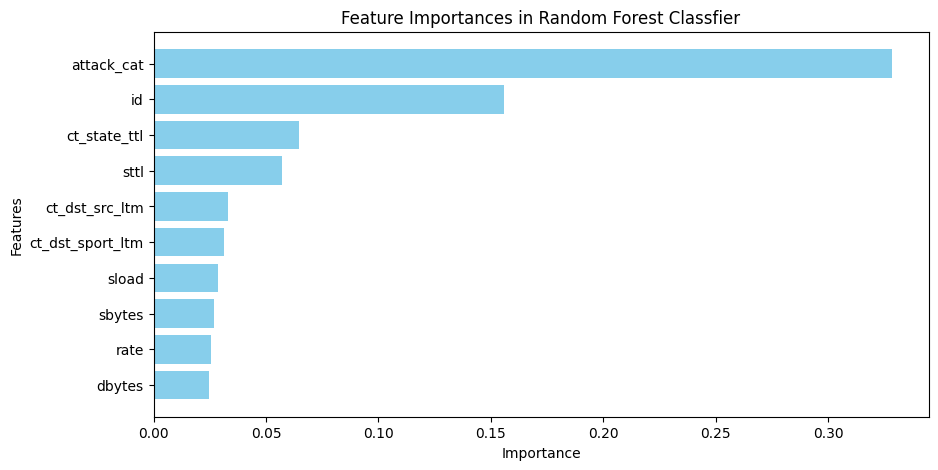

In [635]:
# Plotting Feature Importances of Classifer
values = model.feature_importances_
labels = X_train.columns.values

# Sort the arrays based on values
sorted_indices = np.argsort(values) [::-1]
sorted_values = values[sorted_indices]
sorted_labels = labels[sorted_indices]

# Plot the sorted values
plt.figure(figsize=(10, 5))
plt.barh(sorted_labels [:10], sorted_values[:10], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances in Random Forest Classfier')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest values at the top
plt.show()